In [28]:
# ignore warnings.
import warnings
warnings.filterwarnings('ignore')

# Audio processing
from scipy.io import wavfile

# maths and sci libraries.
import numpy as np
import scipy as sp

# for dict and all.
import collections

# for plotting.
import matplotlib.pyplot as plt

# encoding purpose.
from base64 import b64decode

#pandas for csvs.
import pandas as pd

# import stft
import stft

In [3]:
# create the audio files path.
audio_file = collections.defaultdict(dict)

# initialise the audio songs as (genre, path).
# where path is path of the current .wav audio.

audio_file["rock"]["path"] = r"tomydeepestego.wav"

In [4]:
def audio_length():
    samplerate, wavedata = wavfile.read(audio_file["rock"]["path"])
    audio_file["rock"]["wavedata"] = wavedata
    audio_file["rock"]["samplerate"] = samplerate
    number_of_samples = wavedata.shape[0]
    print samplerate, wavedata.shape[0]
    # song length : number of samples/samplerate.
    print "Audio length: " + str(number_of_samples/samplerate) + " seconds"


In [5]:
audio_length()

44100 16181864
Audio length: 366 seconds


In [6]:
def wavedata_mean():
    audio_file["rock"]["wavedata"] = np.mean(audio_file["rock"]["wavedata"], axis=1)

In [7]:
wavedata_mean()

In [9]:
""" Zero Crossing Rate : Is a time domain feature.
    Simple, straightforward and inexpensive feature to examine the similarity between two sets of time series.
    It is the number of times signal changes sign. It is useful for signals affected by noise.
"""
def zero_crossing_rate_bruteForce(wavedata):
    zero_crossing = 0
    for i in range(1, number_of_samples):
        if (wavedata[i-1] < 0 and wavedata[i]>0) or (wavedata[i-1] > 0 and wavedata[i] < 0) or (wavedata[i-1] != 0 and wavedata[i] == 0):
            zero_crossing += 1;
    zero_crossing_rate = zero_crossing / float(number_of_samples-1)
    return zero_crossing_rate


def zero_crossing_rate(wavedata, block_length, sample_rate):
    # Number of blocks required.
    num_blocks = int(np.ceil(len(wavedata)/block_length))
    
    # Timestamps for the beginning of the blocks.
    timestamps = (np.arange(0, num_blocks - 1) * (block_length/float(sample_rate)))
    
    zcr = []
    for i in range(0, num_blocks - 1):
        start = i*block_length
        stop = np.min([(start + block_length - 1), len(wavedata)])
        zc = 0.5*np.mean(np.abs(np.diff(np.sign(wavedata[start:stop]))))
        zcr.append(zc)
        
    return np.asarray(zcr), np.asarray(timestamps)


In [23]:
zcr, zcr_timestamps = zero_crossing_rate(audio_file["rock"]["wavedata"], 1024, audio_file["rock"]["samplerate"])

In [24]:
zcr

array([ 0.        ,  0.        ,  0.        , ...,  0.02446184,
        0.04354207,  0.03620352])

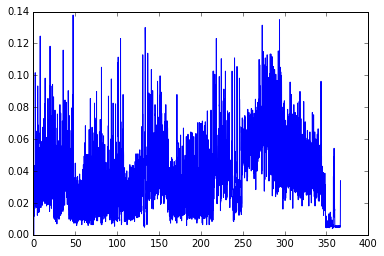

In [13]:
plt.plot(timestamps, zcr)

In [15]:
""" Root mean Square : comparing arbitary waveforms based upon 
    their equivalent energy."""
def root_mean_square(wavedata, block_length, sample_rate):
    num_blocks = int(np.ceil(len(wavedata)/block_length))
    
    timestamps = (np.arange(0, num_blocks-1) * (block_length/float(sample_rate)))
    
    rms = []
    
    for i in range(0, num_blocks-1):
        start = i*block_length
        stop = np.min([(start + block_length -1), len(wavedata)])
        
        rms_seg = np.sqrt(np.mean(wavedata[start:stop]**2))
        rms.append(rms_seg)
    return np.asarray(rms), np.asarray(timestamps)

In [25]:
rms, rms_timestamps = root_mean_square(audio_file["rock"]["wavedata"], 1024, audio_file["rock"]["samplerate"])

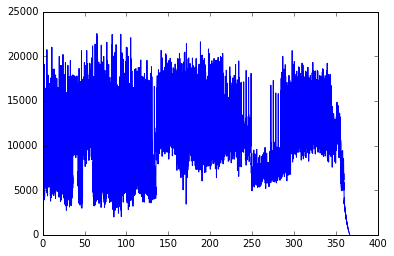

In [26]:
plt.plot(rms_timestamps, rms)

In [31]:
""" Spectral features. """
""" Spectral centroid : centre of gravity.
    Tells the frequency around which most of the signal energy is concentrated.
    Tells how dark/bright the sound is."""
def spectral_centroid(wavedata, window_size, sample_rate):
    magnitude_spectrum = stft.spectrogram(wavedata, window_size)
    timebins, freqbins = np.shape(magnitude_spectrum)
    
    timestamps = (np.arange(0, timebins - 1)*(timebins/float(sample_rate)))
    spec_centroid = []
    
    for t in range(timebins - 1):
        power_spectrum = np.abs(magnitude_spectrum[t])**2
        
        sc_t = np.sum(power_spectrum * np.arange(1, freqbins + 1))/np.sum(power_spectrum)
        
        spec_centroid.append(sc_t)
        
    return np.nan_to_num(np.asarray(spec_centroid)), np.asarray(timestamps)


In [32]:
spec_centroid, spec_ts = spectral_centroid(audio_file["rock"]["wavedata"], 1024, audio_file["rock"]["samplerate"])

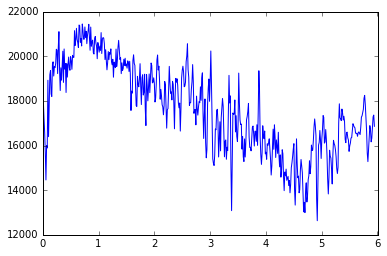

In [33]:
plt.plot(spec_ts, spec_centroid)